## Cross validation

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from typing import Tuple
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle':'--'})

In [2]:
def hstack_higher_order(X: np.array, order: int = 1):
    """Construct a matrix with higher order terms."""
    X_raw = X.reshape(-1, 1)
    X_w_higher_orders = np.zeros(shape=(len(X_raw), order))
    for o in range(order):
        X_w_higher_orders[:, o] = np.power(X_raw, o).reshape(1, -1)
    return X_w_higher_orders

def fit_polynomial(
    X: np.array,
    y: np.array,
    order: int = 1,
) -> Tuple[int, LinearRegression]:
    """Fit a polynomial model to the underlying data."""
    X_fit = hstack_higher_order(X, order)
    # fit the model
    model = LinearRegression()
    model.fit(X_fit, y)
    
    return order, model

auto = pd.read_csv("https://raw.githubusercontent.com/changyaochen/MECE4520/master/data/auto_mpg.csv")
auto.dropna(inplace=True)  # Drop the null values
print(f"The shape of the data is {auto.shape}")
auto.head()

The shape of the data is (392, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino


In [3]:
X = auto["horsepower"].values
y = auto["mpg"].values
n_trials= 10

# CV split
rmse = pd.DataFrame(columns=["trial_index", "order", "train", "validation"])
for t in range(n_trials):
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=(103 + t))

    # fit different polynomials
    for order in range(1, 8):
        _, model = fit_polynomial(X=X_train, y=y_train, order=order)

        y_pred_train = model.predict(hstack_higher_order(X_train, order))
        y_pred_validation = model.predict(hstack_higher_order(X_validation, order))
        row = pd.Series({
            "trial_index": t,
            "order": order,
            "train": np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred_train)),
            "validation": np.sqrt(mean_squared_error(y_true=y_validation, y_pred=y_pred_validation)),
        })
        rmse = pd.concat((rmse, row.to_frame().T), ignore_index=True)
rmse

,trial_index,order,train,validation
0,0.0,1.0,7.894118,7.407799
1,0.0,2.0,4.891589,4.904329
2,0.0,3.0,4.279975,4.661947
3,0.0,4.0,4.276973,4.652892
4,0.0,5.0,4.257462,4.698976
...,...,...,...,...
65,9.0,3.0,4.439830,4.034965
66,9.0,4.0,4.439095,4.022879
67,9.0,5.0,4.420359,4.076875
68,9.0,6.0,4.373246,3.986506


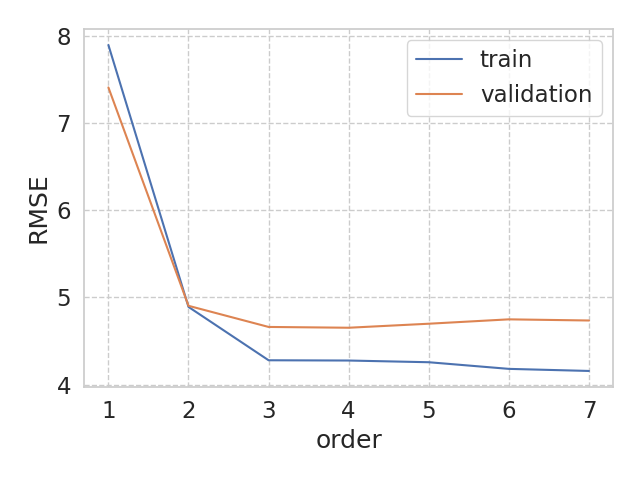

In [4]:
trial_index = 0

plt.figure()
sns.lineplot(x="order", y="train", data=rmse[rmse["trial_index"] == trial_index], label="train")
sns.lineplot(x="order", y="validation", data=rmse[rmse["trial_index"] == trial_index], label="validation")

plt.gca().set_ylabel("RMSE")
plt.tight_layout()
plt.show()

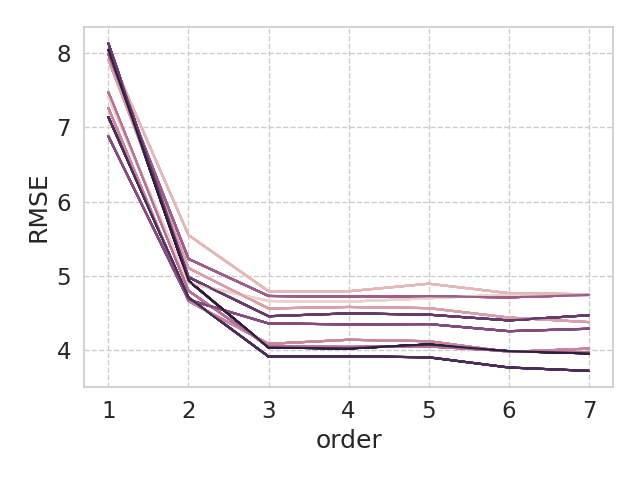

In [5]:
plt.figure()
for t in range(n_trials):
    sns.lineplot(x="order", y="validation", data=rmse, hue="trial_index")

plt.gca().set_ylabel("RMSE")
plt.gca().get_legend().remove()
plt.tight_layout()
plt.show()